In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ctgan import CTGAN
from ctgan import load_demo
import data_describe as dd
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures

In [5]:
data = pd.read_csv('../data/S&P 500 Communication Services 50-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data

,date,S&P 500,S&P 500 Real Estate (Sector),S&P 500 Performance (%),S&P 500 Communication Services (Sector) Performance (%),S&P 500 Communication Services (Sector) Outperform/Underperform,overall,communication,information technology commodities,education and communication commodities,education and communication services
4178,2009-12-02,1109.24,112.279999,1.312485,8.044651,OUTPERFORM,217.488,84.972,100.047,100.150,100.083
4179,2009-12-03,1099.92,112.510002,0.037289,7.923263,OUTPERFORM,217.488,84.972,100.047,100.150,100.083
4180,2009-12-04,1105.98,112.750000,-0.069573,8.319727,OUTPERFORM,217.488,84.972,100.047,100.150,100.083
4181,2009-12-07,1103.25,114.540001,-0.533732,10.400001,OUTPERFORM,217.488,84.972,100.047,100.150,100.083
4182,2009-12-08,1091.94,113.620003,-1.450348,9.798995,OUTPERFORM,217.488,84.972,100.047,100.150,100.083
...,...,...,...,...,...,...,...,...,...,...,...
7194,2021-11-24,4701.46,271.019989,4.852728,13.649511,OUTPERFORM,280.126,76.330,47.997,67.834,116.681
7195,2021-11-26,4594.62,265.980011,1.616263,11.648413,OUTPERFORM,280.126,76.330,47.997,67.834,116.681
7196,2021-11-29,4655.27,268.959991,1.484354,10.197887,OUTPERFORM,280.126,76.330,47.997,67.834,116.681
7197,2021-11-30,4567.00,260.899994,1.396956,8.423716,OUTPERFORM,280.126,76.330,47.997,67.834,116.681


## Using all data

In [6]:
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data

,year,month,date,S&P 500,S&P 500 Real Estate (Sector),S&P 500 Performance (%),S&P 500 Communication Services (Sector) Performance (%),S&P 500 Communication Services (Sector) Outperform/Underperform,overall,communication,information technology commodities,education and communication commodities,education and communication services,dow
0,2009,12,2009-12-10,1102.35,114.449997,-0.261482,11.256920,OUTPERFORM,217.488,84.972,100.047,100.150,100.083,3
1,2010,1,2010-01-14,1148.46,108.800003,-2.110431,-0.229253,OUTPERFORM,217.281,84.849,99.258,99.904,100.205,3
2,2010,2,2010-02-11,1078.47,103.440002,-11.020997,-3.597391,OUTPERFORM,217.353,84.868,99.067,99.781,100.441,3
3,2010,3,2010-03-11,1150.24,106.089996,5.750719,3.080060,UNDERPERFORM,217.403,84.840,98.406,99.447,100.672,3
4,2010,4,2010-04-08,1186.44,107.980003,6.168177,1.019744,UNDERPERFORM,217.290,84.738,97.553,99.069,100.829,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2021,7,2021-07-08,4320.82,265.809998,-2.530346,-5.006793,UNDERPERFORM,273.092,76.056,48.787,68.796,115.826,3
140,2021,8,2021-08-12,4460.83,276.720001,-1.849766,2.633338,OUTPERFORM,274.214,76.337,49.162,69.155,116.228,3
141,2021,9,2021-09-09,4493.28,285.880005,-4.490556,3.684899,OUTPERFORM,276.590,76.407,48.847,68.823,116.446,3
142,2021,10,2021-10-14,4438.26,271.589996,-7.366228,-0.172757,OUTPERFORM,278.524,76.317,48.278,68.130,116.565,3


In [8]:
original = data[['S&P 500 Communication Services (Sector) Outperform/Underperform','month','overall','communication',\
                'information technology commodities','education and communication commodities',\
                'education and communication services']]

In [9]:
data.drop(columns=['date','S&P 500 Communication Services (Sector) Outperform/Underperform','year'], inplace=True)
data.head()

,month,S&P 500,S&P 500 Real Estate (Sector),S&P 500 Performance (%),S&P 500 Communication Services (Sector) Performance (%),overall,communication,information technology commodities,education and communication commodities,education and communication services,dow
0,12,1102.35,114.449997,-0.261482,11.256920,217.488,84.972,100.047,100.150,100.083,3
1,1,1148.46,108.800003,-2.110431,-0.229253,217.281,84.849,99.258,99.904,100.205,3
2,2,1078.47,103.440002,-11.020997,-3.597391,217.353,84.868,99.067,99.781,100.441,3
3,3,1150.24,106.089996,5.750719,3.080060,217.403,84.840,98.406,99.447,100.672,3
4,4,1186.44,107.980003,6.168177,1.019744,217.290,84.738,97.553,99.069,100.829,3


In [11]:
original['Performance'] = np.where(original['S&P 500 Communication Services (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','communication',\
                'information technology commodities','education and communication commodities',\
                'education and communication services']]

In [12]:
dd.data_summary(original)

,Info
Rows,144
Columns,7
Size in Memory,8.0 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,1,1,0.59,0.49,2,85
month,int64,0,0,1,6.50,12,6.50,3.45,12,12
overall,float64,0,0,217.20,238.025,280.13,241.74,14.75,142,2
communication,float64,0,0,72.92,79.92,84.97,78.97,4.10,142,2
information technology commodities,float64,0,0,46.58,61.98,100.047,66.77,15.78,144,1
education and communication commodities,float64,0,0,66.13,81.50,100.15,82.43,10.090,144,1
education and communication services,float64,0,0,100.083,109.15,116.68,108.65,4.11,144,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

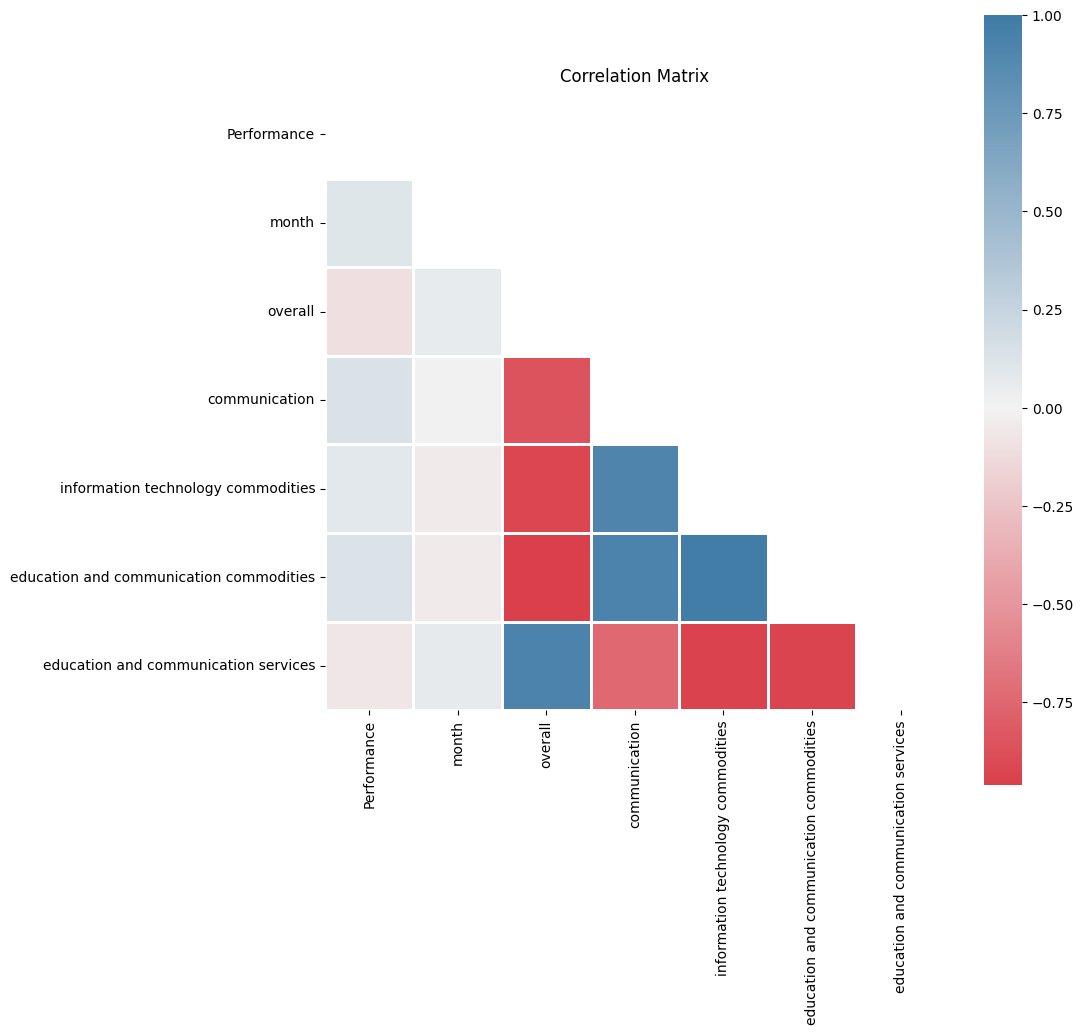

In [13]:
dd.correlation_matrix(original)

### Conditional GAN

In [14]:
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Real Estate (Sector),S&P 500 Performance (%),S&P 500 Communication Services (Sector) Performance (%),overall,communication,information technology commodities,education and communication commodities,education and communication services,dow
0,8,1275.265362,117.534171,0.761091,-1.339794,226.024190,83.117454,86.781846,106.472211,99.736509,3
1,8,2874.231134,178.596342,-4.932990,-5.281080,258.994550,73.204422,50.491200,70.475264,116.520552,3
2,9,1941.379567,155.101706,-1.214985,0.501017,240.387768,78.590861,55.352843,69.565470,112.603249,3
3,3,3929.355156,254.222804,-4.714717,-4.617062,264.354817,74.700207,44.892997,63.384320,116.393152,3
4,6,1815.764145,157.063774,-2.248116,-1.084791,232.618397,80.831691,56.538569,79.352319,110.286527,3
...,...,...,...,...,...,...,...,...,...,...,...
9995,7,1428.975966,125.852573,-6.038648,-6.725203,229.293166,83.535217,88.726812,97.727116,103.202111,3
9996,2,1572.327575,144.503255,-0.417069,-3.885835,223.430809,81.862855,86.447095,93.262333,108.022734,3
9997,11,1785.397645,126.798931,-11.075193,-6.761981,229.517481,80.804204,76.544462,94.112011,106.678672,3
9998,2,3015.519620,164.107015,-6.898960,-9.951067,239.140693,72.970685,49.434133,67.247830,111.611157,3


In [15]:
samples['Performance'] = np.where(samples['S&P 500 Communication Services (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)

In [16]:
samples = samples[['Performance','month', 'overall','communication',\
                'information technology commodities','education and communication commodities',\
                'education and communication services']]
samples.head()

,Performance,month,overall,communication,information technology commodities,education and communication commodities,education and communication services
0,0,8,226.024190,83.117454,86.781846,106.472211,99.736509
1,0,8,258.994550,73.204422,50.491200,70.475264,116.520552
2,1,9,240.387768,78.590861,55.352843,69.565470,112.603249
3,1,3,264.354817,74.700207,44.892997,63.384320,116.393152
4,1,6,232.618397,80.831691,56.538569,79.352319,110.286527


In [17]:
dd.data_summary(samples)

,Info
Rows,10000
Columns,7
Size in Memory,547.0 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,0,1,0.38,0.49,2,6179
month,int64,0,0,1,6,12,6.54,3.42,12,896
overall,float64,0,0,207.098,240.89,286.90,243.46,15.41,9999,2
communication,float64,0,0,70.59,79.95,86.55,78.37,3.97,10000,1
information technology commodities,float64,0,0,37.015,68.62,122.99,68.61,17.49,10000,1
education and communication commodities,float64,0,0,56.19,80.23,108.46,80.86,11.26,9999,2
education and communication services,float64,0,0,98.29,109.67,122.30,109.18,4.43,10000,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

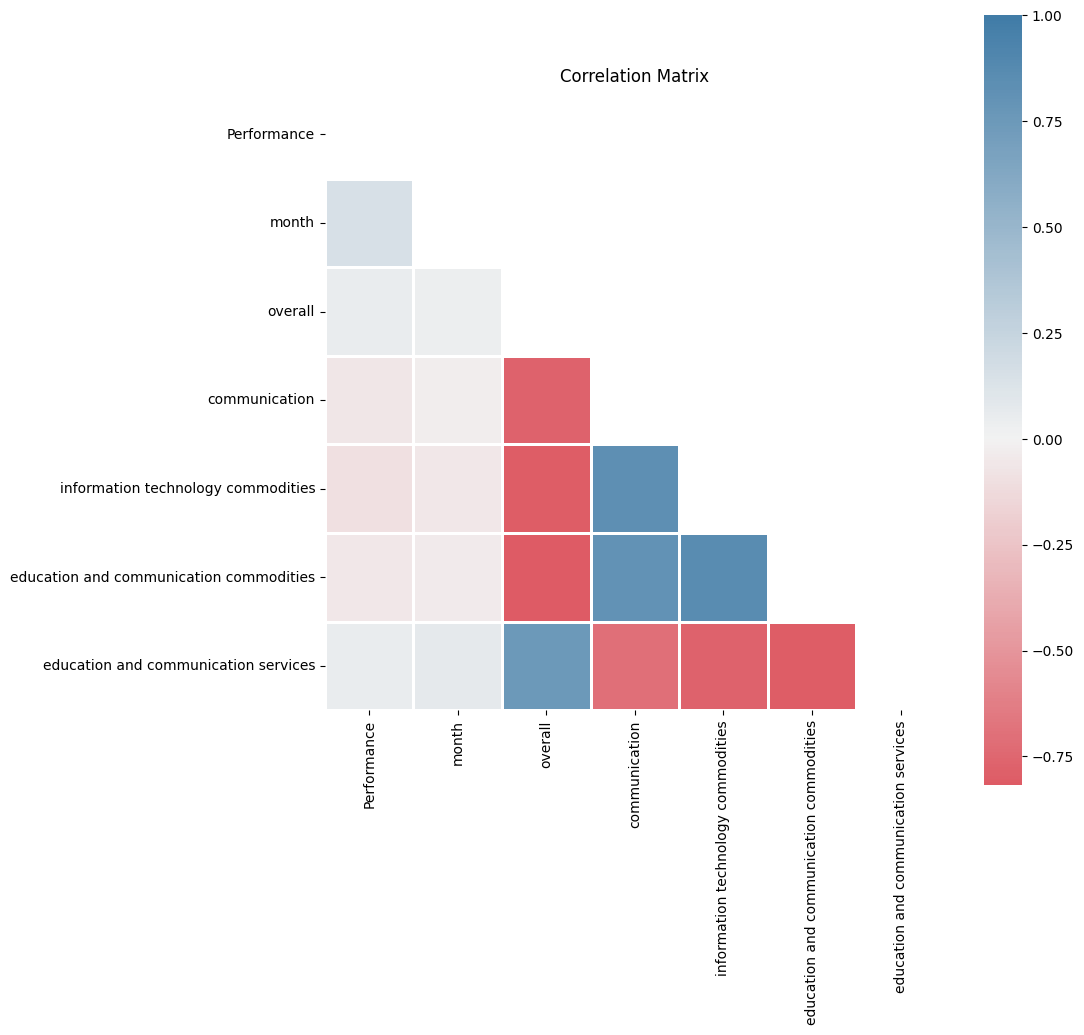

In [18]:
dd.correlation_matrix(samples)

In [19]:
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']

### SMOTE Oversampling

In [20]:
counter = Counter(y)
print(counter)
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({0: 6179, 1: 3821})
Counter({0: 6179, 1: 6179})


### Interaction Terms

In [21]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
X_poly

array([[  226.02419006,    83.11745424,    86.78184608, ...,
         9239.85506973,  8655.3184149 , 10619.16673197],
       [  258.99454998,    73.20442172,    50.49120026, ...,
         3558.38064841,  5883.26250606,  8211.8165918 ],
       [  240.38776772,    78.59086148,    55.3528427 , ...,
         3850.64650866,  6232.90993919,  7833.29793325],
       ...,
       [  253.7691193 ,    80.32071688,    83.53728188, ...,
         7323.22126141,  9231.95931609,  9688.02738159],
       [  238.96016345,    80.79071157,    76.46691754, ...,
         6980.95065125,  8284.81025666,  9891.22240168],
       [  230.97841336,    80.81970762,    52.65777803, ...,
         4759.32314169,  5783.59097316,  9926.99275971]])

In [22]:
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X.shape

(12358, 16)

In [23]:
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
X_real.shape

(144, 16)

In [24]:
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)

### Training with CV

In [25]:
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.648251,0.627426,0.724084,0.671515,0.636246,0.612812,0.71025,0.657943,0.5625,0.666667,0.517647,0.582781
1,DecisionTreeClassifier,0.626808,0.617941,0.654816,0.634902,0.612621,0.598425,0.649146,0.622754,0.520833,0.648148,0.411765,0.503597
2,RandomForestClassifier,0.713396,0.705111,0.725546,0.712925,0.702913,0.688986,0.72339,0.705769,0.513889,0.631579,0.423529,0.507042
3,AdaBoostClassifier,0.61887,0.619333,0.617575,0.618359,0.613592,0.603535,0.628121,0.615583,0.486111,0.57971,0.470588,0.519481
4,GradientBoostingClassifier,0.631414,0.636118,0.614664,0.624914,0.629126,0.620359,0.636662,0.628405,0.479167,0.578125,0.435294,0.496644
5,ExtraTreesClassifier,0.736297,0.72759,0.74756,0.734192,0.717476,0.70525,0.732589,0.718659,0.555556,0.698113,0.435294,0.536232
6,BaggingClassifier,0.668239,0.680598,0.62763,0.651095,0.660518,0.665269,0.625493,0.644768,0.486111,0.603774,0.376471,0.463768
7,SVC,0.598478,0.603036,0.577924,0.590006,0.598058,0.593209,0.585414,0.589286,0.513889,0.6,0.529412,0.5625
8,GaussianNB,0.541595,0.536708,0.602048,0.567319,0.53754,0.527466,0.586728,0.555521,0.472222,0.551724,0.564706,0.55814


### Voting Classifier

In [26]:
et_clf = ExtraTreesClassifier(random_state=random_state)
bag_clf = BaggingClassifier(random_state=random_state)
rf_clf = RandomForestClassifier(random_state=random_state)
classifiers = [('RF', rf_clf), \
               ('ET', et_clf),\
              ('Bagging', bag_clf)]

vc = VotingClassifier(estimators = classifiers, voting = 'soft')     
vc.fit(x_train, y_train)
y_pred = vc.predict(x_test)
vc_res = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F-1 Score'])
vc_res.loc[0, 'Accuracy'] = accuracy_score(y_test, y_pred)
vc_res.loc[0, 'Precision'] = precision_score(y_test, y_pred)
vc_res.loc[0, 'Recall'] = recall_score(y_test, y_pred)
vc_res.loc[0, 'F-1 Score'] = f1_score(y_test, y_pred)
vc_res

,Accuracy,Precision,Recall,F-1 Score
0,0.70356,0.688433,0.727332,0.707348
